---
title: "`Autogluon`과 시계열 자료 분석(?) : 합리적 정보"
author: "강신성"
date: "2023-12-10"
categories: [autogluon]
---




> 과거 관측치 이외의 요인을 포함한 시계열자료를 분석해보자.

## 1. 라이브러리 imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
#---#}
from autogluon.tabular import TabularPredictor  ## 테뷸러데이터도 따로 적합?
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.common import space
#---#
import warnings
warnings.filterwarnings('ignore')

## 2. 데이터

ref : [kaggle competition](https://www.kaggle.com/competitions/bike-sharing-demand)

In [2]:
!kaggle competitions download -c bike-sharing-demand


  0%|          | 0.00/189k [00:00<?, ?B/s]
100%|##########| 189k/189k [00:00<00:00, 816kB/s]
100%|##########| 189k/189k [00:00<00:00, 816kB/s]


In [3]:
!unzip bike-sharing-demand.zip -d data

Archive:  bike-sharing-demand.zip
  inflating: data/sampleSubmission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [4]:
sampleSubmission = pd.read_csv('data/sampleSubmission.csv')
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [5]:
!rm -rf data
!rm bike-sharing-demand.zip

`-` 자료 관찰

In [6]:
df_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [7]:
set(df_train.columns) - set(df_test.columns)

{'casual', 'count', 'registered'}

> 다른 부분이 세 개나 된다??

`-` 시계열 분석을 해야 하나?

* 시간별로 정리된 시계열 자료이긴 하다.

In [8]:
display('train', df_train.iloc[::24][:20], 'test', df_test.iloc[:10])

'train'

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
24,2011-01-02 00:00:00,1,0,0,2,18.86,22.725,88,19.9995,4,13,17
48,2011-01-03 01:00:00,1,0,1,1,8.20,8.335,44,27.9993,0,2,2
72,2011-01-04 04:00:00,1,0,1,1,5.74,9.090,63,6.0032,0,2,2
96,2011-01-05 05:00:00,1,0,1,1,9.02,11.365,47,11.0014,0,3,3
120,2011-01-06 06:00:00,1,0,1,2,5.74,8.335,63,7.0015,0,36,36
144,2011-01-07 07:00:00,1,0,1,1,8.20,10.605,69,8.9981,8,76,84
168,2011-01-08 07:00:00,1,0,0,2,6.56,9.090,74,7.0015,1,8,9
192,2011-01-09 07:00:00,1,0,0,1,3.28,4.545,53,12.9980,1,5,6
216,2011-01-10 07:00:00,1,0,1,1,4.92,6.060,50,15.0013,2,75,77


'test'

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
5,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013
6,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013
7,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013
8,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012
9,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013


> `df_train`의 형태를 볼 때, 비어있는 시간이 있는 것을 알 수 있다. 즉, 테스트 데이터는 중간중간에서 추출되었다.(20일, 10일, 20일 10일 이런 식으로...)

`-` 데이터 분석 전략

* 오히려 시계열을 피쳐엔지니어링하여 회귀문제로 바꾸는 게 적절하다.
* 시계열 -> 요일, 시간의 피쳐 추출 + **외부자료**를 활용하여 휴일 유무 체크 + **외부자료**를 활용하여 해당 요일의 날씨 체크 -> 회귀문제로 해석!

## 3. 적합

### **A. 적합**
---




In [9]:
set(df_train.columns) - set(df_test.columns)

{'casual', 'count', 'registered'}

> 예측해야할 변수는 `count`에 해당함

`-` 데이터 전처리 : step 1

In [10]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()

df_train_featured = df_train_featured.drop(['casual', 'registered'], axis = 1)  ## 그냥 드롭해버림

`-` `predictor` 생성 및 적합, 예측

In [11]:
## step 2
predictr = TabularPredictor(label = 'count')

## step 3
predictr.fit(df_train_featured)

## step 4
yhat = predictr.predict(df_train_featured)
yyhat = predictr.predict(df_test_featured)

No path specified. Models will be saved in: "AutogluonModels\ag-20231219_141357"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231219_141357"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
Memory Avail:      

[1000]	valid_set's rmse: 136.065


	-135.958	 = Validation score   (-root_mean_squared_error)
	2.22s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBM ...
	-134.0804	 = Validation score   (-root_mean_squared_error)
	0.92s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-122.0136	 = Validation score   (-root_mean_squared_error)
	6.69s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-134.2362	 = Validation score   (-root_mean_squared_error)
	7.9s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-128.4202	 = Validation score   (-root_mean_squared_error)
	3.52s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-136.0344	 = Validation score   (-root_mean_squared_error)
	33.31s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: XGBoost ...
	-135.0751	 = Validation score   (-root_mean_squared_error)
	2.32s	 = Training   runtime
	0.02s	 = Validati

`-` 적합한 것을 관찰해보자.

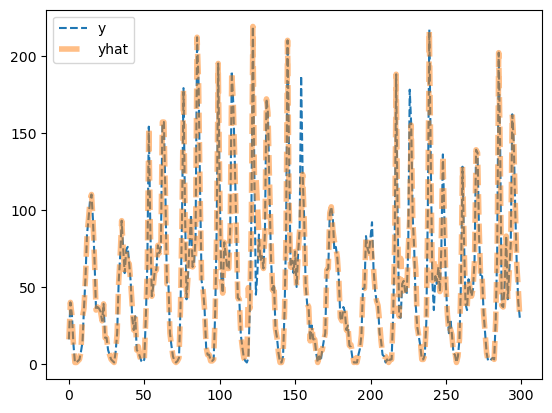

In [12]:
plt.plot(df_train['count'][:300], '--', label = 'y')
plt.plot(yhat[:300], '--', label = 'yhat', alpha = 0.5, lw = 4)
plt.legend()

> 거의 동일하다. 이상하리만치 적합이 잘 되어있다. (왜 이렇게 잘맞춤???)

### **B. 제출**
---




In [13]:
submission = sampleSubmission.copy()
submission

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


In [14]:
submission['count'] = yyhat

In [15]:
submission.to_csv('submission.csv', index = False)
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "autogloun tabular predict"
!rm submission.csv

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/195k [00:00<?, ?B/s]
  8%|8         | 16.0k/195k [00:00<00:05, 31.9kB/s]
 74%|#######3  | 144k/195k [00:00<00:00, 306kB/s]  
100%|##########| 195k/195k [00:02<00:00, 85.1kB/s]


`-` 순위 확인...

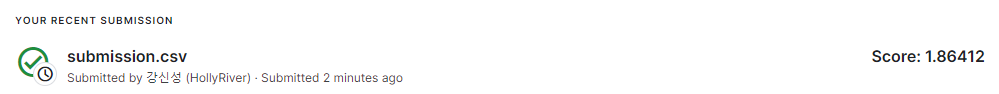

> 상당히 충격적인 결과, 냈다면 3171/3242등임...

`-` yyhat을 살펴보면...

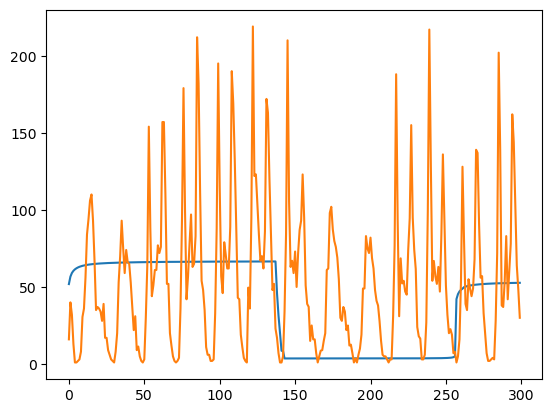

In [16]:
plt.plot(yyhat[:300])
plt.plot(yhat[:300])

> `yhat`이랑 근본적으로 모양 자체가 다름...(요일이나 뭐 그런거나 다 신경쓰지 않고 뭉툭하게 적합하였음.)

## 4. 적합 2

불필요한 변수가 있거나, 공선성이 있거나, y와 완전히 관련된 변수가 따로 있나?

### **A. 피쳐 엔지니어링**
---




`-` 일단 시계열로 적합할 생각이 없으므로, `datetime` 열은 삭제하는 게 좋겠음(인덱스 역할만 하는 쓸모없는 변수임)

In [17]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)  ## 추가적으로 'datetime' 열을 제거하였음.
df_test_featured = df_test_featured.drop(['datetime'],axis=1)

### **B. 적합**
---




`-` 동일하게 적합...

In [18]:
## step 2
predictr = TabularPredictor(label = 'count')

## step 3
predictr.fit(df_train_featured, verbosity = False)  ## 적합 과정을 말 많이 하지 말라고 하는 거

## step 4
yhat = predictr.predict(df_train_featured)
yyhat = predictr.predict(df_test_featured)

No path specified. Models will be saved in: "AutogluonModels\ag-20231219_141721"


`-` 적합결과 시각화

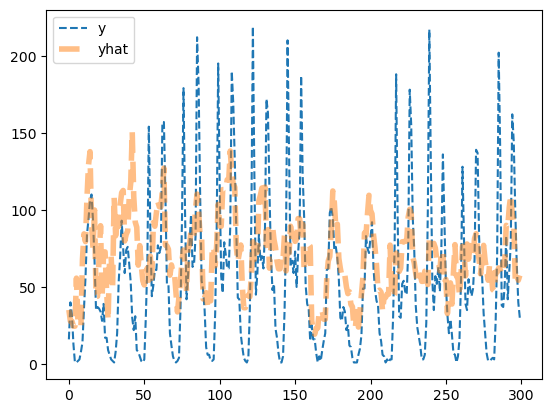

In [19]:
plt.plot(df_train['count'][:300], '--', label = 'y')
plt.plot(yhat[:300], '--', label = 'yhat', alpha = 0.5, lw = 4)
plt.legend()

> 너무 잘 적합되는 것을 벗어났다.(오히려 좋아.)

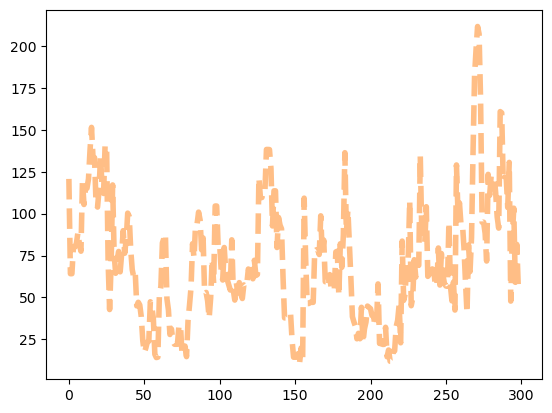

In [20]:
plt.plot(yyhat[:300], '--', alpha = 0.5, lw = 4, color = 'C1')

`-` 더 깔끔하고 예쁜 시각화(`seaborn`)

In [21]:
df = pd.concat([df_train, df_test]).assign(datetime = lambda _df : _df.datetime.apply(pd.to_datetime))\
.assign(count_hat = yhat.tolist() + yyhat.tolist(), dataset_type = ['train']*len(yhat) + ['test']*len(yyhat))

In [22]:
df.to_csv('df.csv', index = False)

> `test`와 `train`을 따로 시각화해버리면 시간이 연속되지 않아 이상함.

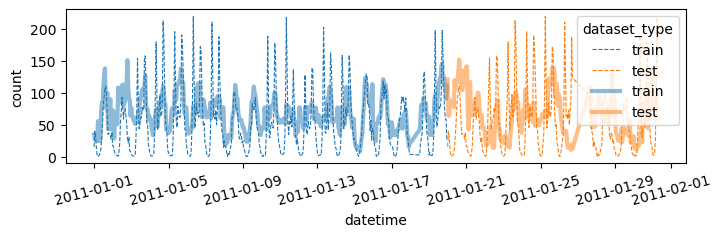

In [23]:
sns.lineplot(
    df.sort_values('datetime')[:(24*28)], ## 28일에 해당하는 자료만 시각화
    x = 'datetime', y = 'count',
    hue = 'dataset_type', linestyle = '--',
    lw = 0.8
)

sns.lineplot(
    df.sort_values('datetime')[:(24*28)],
    x = 'datetime', y = 'count_hat',
    hue = 'dataset_type',
    lw = 3, alpha = 0.5
)

fig = plt.gcf()
fig.set_size_inches(8,2)  ## 사이즈 조절
plt.xticks(rotation = 15);  ## x축 눈금 회전시키기

> 왜 `test` 데이터의 실제 관측치가 보이는 지는 모르겠지만(`matplotlib`에서는 결측치를 표기하지 않았었음...) 전보다는 나아보임.

<span style='background-color:red'>**`seaborn`의 버그로, 인덱스를 초기화하면 해당 문제가 해결된다!!**</span>

In [24]:
def plotting(yhat, yyhat) :
    df = pd.concat([df_train, df_test]).assign(datetime = lambda _df : _df.datetime.apply(pd.to_datetime))\
.assign(count_hat = yhat.tolist() + yyhat.tolist(), dataset_type = ['train']*len(yhat) + ['test']*len(yyhat)).reset_index(drop = True)
    sns.lineplot(
        df.sort_values('datetime')[:(24*28)], ## 28일에 해당하는 자료만 시각화
        x = 'datetime', y = 'count',
        hue = 'dataset_type', linestyle = '--',
        lw = 0.8
    )
    
    sns.lineplot(
        df.sort_values('datetime')[:(24*28)],
        x = 'datetime', y = 'count_hat',
        hue = 'dataset_type',
        lw = 3, alpha = 0.5
    )
    
    fig = plt.gcf()
    fig.set_size_inches(8,2)  ## 사이즈 조절
    plt.xticks(rotation = 15);  ## x축 눈금 회전시키기
    fig.show()

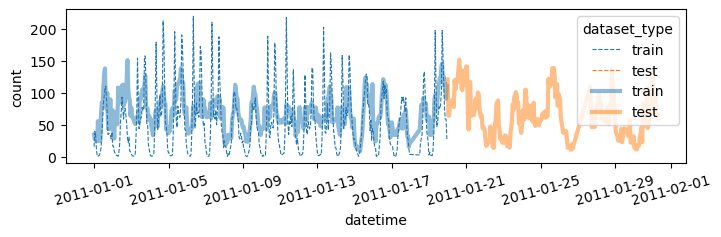

In [25]:
plotting(yhat, yyhat)

### **C. 제출**
---




`-` 제출도 자동화...

In [26]:
submission['count'] == yyhat
submission.to_csv('submission.csv', index = False)
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Message"
!rm submission.csv

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/195k [00:00<?, ?B/s]
  8%|8         | 16.0k/195k [00:00<00:05, 32.4kB/s]
 74%|#######3  | 144k/195k [00:00<00:00, 303kB/s]  
100%|##########| 195k/195k [00:02<00:00, 92.9kB/s]


In [27]:
def submit(yyhat) :
    submission['count'] = yyhat
    submission.to_csv('submission.csv', index = False)
    !kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Message"
    !rm submission.csv

In [28]:
submit(0)

Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/146k [00:00<?, ?B/s]
 11%|#         | 16.0k/146k [00:00<00:04, 33.0kB/s]
100%|##########| 146k/146k [00:02<00:00, 67.1kB/s] 


> 이게 된다.

### **D. Pipeline Automation -- 싹 다 함수로 구현**
---




* 근데, 값이 음수라면 0이상이도록 정의해야 할 것 같음

In [29]:
submission['count'].apply(lambda x : x if x>0 else 0)  ## 음수일 경우 싹 다 0으로 바꿔서 표기, 중요한 테크닉

0       0
1       0
2       0
3       0
4       0
       ..
6488    0
6489    0
6490    0
6491    0
6492    0
Name: count, Length: 6493, dtype: int64

In [30]:
def submit(yyhat) :
    submission['count'] = yhat
    submission['count'] = submission['count'].apply(lambda x : x if x>0 else 0)
    submission.to_csv('submission.csv', index = False)
    !kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Message"
    !rm submission.csv

* 적합하는 코드

In [31]:
def fit_predict(df_train_featured, df_test_featured) :
    ## step 1 : pass -- 이미 정리된 데이터프레임을 넣어야 함
    ## step 2
    predictr = TabularPredictor(label = 'count', verbosity = False)
    ## step 3
    predictr.fit(df_train_featured)
    ## step 4
    yhat = predictr.predict(df_train_featured)
    yyhat = predictr.predict(df_test_featured)
    ## display
    display(predictr.leaderboard())
    return yhat, yyhat

* 위 두개를 엮어서 제출까지 한번에

In [32]:
def auto(df_train_featured, df_test_featured) :
    yhat, yyhat = fit_predict(df_train_featured, df_test_featured)
    plotting(yhat, yyhat)
    submit(yyhat)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-147.011268,root_mean_squared_error,0.259508,168.826643,0.000000,0.228424,2,True,12
1,CatBoost,-148.454154,root_mean_squared_error,0.002986,2.770997,0.002986,2.770997,1,True,6
2,LightGBMLarge,-149.213280,root_mean_squared_error,0.000000,1.175117,0.000000,1.175117,1,True,11
3,LightGBMXT,-149.261116,root_mean_squared_error,0.015612,1.413615,0.015612,1.413615,1,True,3
4,NeuralNetFastAI,-149.277322,root_mean_squared_error,0.031256,30.775120,0.031256,30.775120,1,True,8
5,XGBoost,-149.642096,root_mean_squared_error,0.000000,0.736158,0.000000,0.736158,1,True,9
6,LightGBM,-149.739171,root_mean_squared_error,0.004533,0.549370,0.004533,0.549370,1,True,4
7,NeuralNetTorch,-151.158896,root_mean_squared_error,0.046870,125.951475,0.046870,125.951475,1,True,10
8,ExtraTreesMSE,-156.632991,root_mean_squared_error,0.079110,2.895849,0.079110,2.895849,1,True,7
9,RandomForestMSE,-157.475521,root_mean_squared_error,0.083674,3.616045,0.083674,3.616045,1,True,5


Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/249k [00:00<?, ?B/s]
  6%|6         | 16.0k/249k [00:00<00:06, 36.3kB/s]
 51%|#####1    | 128k/249k [00:00<00:00, 303kB/s]  
100%|##########| 249k/249k [00:02<00:00, 122kB/s]


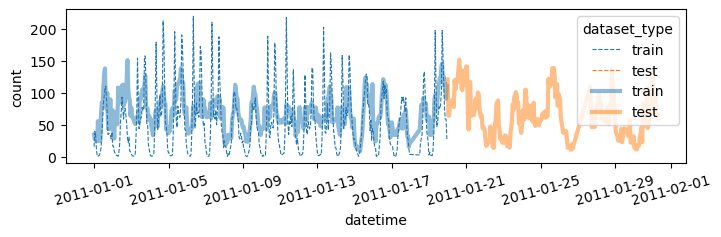

In [33]:
auto(df_train_featured, df_test_featured)

## 5. 적합 3

### **A. 시간 정보 피쳐엔지니어링**
---




* 시계열 자료에서 뽑아낼 수 있는 정보들을 추가적으로 넣어주고 싶다.

In [34]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()

df_train_featured = df_train_featured.drop(['casual', 'registered'], axis = 1)  ## 안겹치는 거 제거

df_train_featured.datetime = pd.to_datetime(df_train_featured.datetime)
df_test_featured.datetime = pd.to_datetime(df_test_featured.datetime)

## 시간 정보 매우 중요해보임
df_train_featured['hour'] = df_train_featured['datetime'].dt.hour
df_test_featured['hour'] = df_test_featured['datetime'].dt.hour

## 요일 정보도 중요해보임(추가적으로 공휴일 정보도 있으면 좋긴 함)
df_train_featured['weekday'] = df_train_featured['datetime'].dt.weekday
df_test_featured['weekday'] = df_test_featured['datetime'].dt.weekday

## 이제 쓸모없는 변수이니 드롭
df_train_featured = df_train_featured.drop(['datetime'], axis = 1)
df_test_featured = df_test_featured.drop('datetime', axis = 1)

### **B. 적합, 시각화, 제출**
---




,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-59.253634,root_mean_squared_error,0.400088,337.272484,0.000000,0.294752,2,True,12
1,LightGBMLarge,-60.899261,root_mean_squared_error,0.015628,1.973689,0.015628,1.973689,1,True,11
2,CatBoost,-61.268467,root_mean_squared_error,0.015622,74.992757,0.015622,74.992757,1,True,6
3,LightGBM,-61.447456,root_mean_squared_error,0.074325,3.401771,0.074325,3.401771,1,True,4
4,XGBoost,-61.749260,root_mean_squared_error,0.017574,1.455093,0.017574,1.455093,1,True,9
5,LightGBMXT,-62.400538,root_mean_squared_error,0.220193,7.427155,0.220193,7.427155,1,True,3
6,RandomForestMSE,-67.993659,root_mean_squared_error,0.062920,5.569473,0.062920,5.569473,1,True,5
7,ExtraTreesMSE,-68.246611,root_mean_squared_error,0.067227,2.922439,0.067227,2.922439,1,True,7
8,NeuralNetTorch,-68.581209,root_mean_squared_error,0.056746,247.727266,0.056746,247.727266,1,True,10
9,NeuralNetFastAI,-70.652709,root_mean_squared_error,0.028053,30.274187,0.028053,30.274187,1,True,8


Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/249k [00:00<?, ?B/s]
  6%|6         | 16.0k/249k [00:00<00:06, 37.2kB/s]
 51%|#####1    | 128k/249k [00:00<00:00, 289kB/s]  
100%|##########| 249k/249k [00:02<00:00, 99.8kB/s]


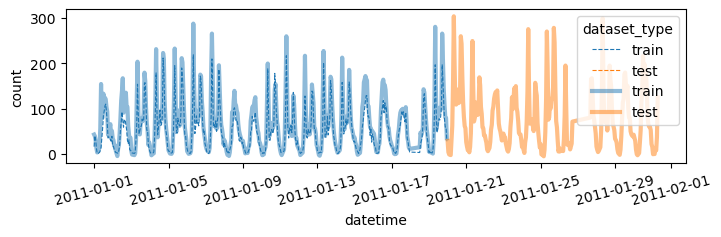

In [35]:
auto(df_train_featured, df_test_featured)

> 매우 좋은 결과...

## 6. 추가적인 피쳐엔지니어링

### **A. Step 1 : 관련없는 변수 삭제**
---




`-` 지금까지 수행했던 피쳐 엔지니어링

In [36]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)
df_test_featured = df_test_featured.drop(['datetime'],axis=1)

`-` 변수 간 상관계수를 나타내는 히트맵 작성

<Axes: >

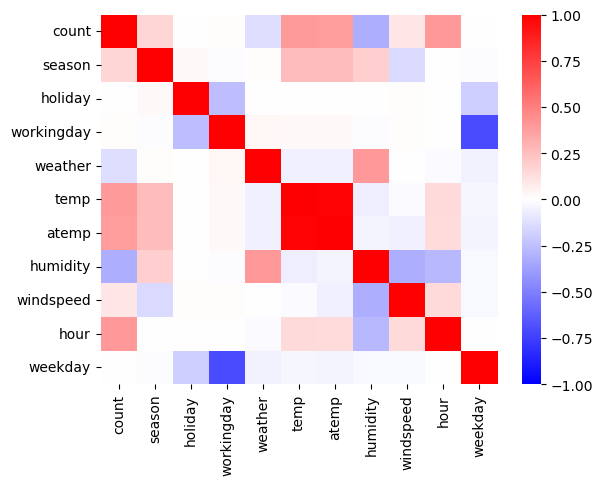

In [37]:
sns.heatmap(df_train_featured.set_index('count').reset_index().corr(), vmin = -1, cmap = 'bwr')
## count를 인덱스로 넣고 리셋하여 count를 맨 위로 뺌
## vmin을 -1로 설정하여 상관계수 최소값을 명시(자신과의 상관이 1이기 때문에 max는 자동으로 1임)
## cmap을 blue, white, red로 선택하여 0에 가까울수록 하얗게 만들었다.

> 어? `holiday`, `workingday`, `weekday`는 `count`와 관련이 없어보인다. $\to$ 제외하고 분석

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-100.653085,root_mean_squared_error,0.180078,231.830386,0.000000,0.245939,2,True,12
1,CatBoost,-101.264453,root_mean_squared_error,0.002520,2.964565,0.002520,2.964565,1,True,6
2,LightGBMXT,-102.499627,root_mean_squared_error,0.031248,1.423626,0.031248,1.423626,1,True,3
3,LightGBMLarge,-102.767101,root_mean_squared_error,0.005979,1.176866,0.005979,1.176866,1,True,11
4,XGBoost,-103.481823,root_mean_squared_error,0.000000,0.705198,0.000000,0.705198,1,True,9
5,LightGBM,-103.565687,root_mean_squared_error,0.000000,0.691696,0.000000,0.691696,1,True,4
6,NeuralNetTorch,-105.303000,root_mean_squared_error,0.089703,195.218086,0.089703,195.218086,1,True,10
7,RandomForestMSE,-106.376977,root_mean_squared_error,0.066255,3.948802,0.066255,3.948802,1,True,5
8,NeuralNetFastAI,-106.635814,root_mean_squared_error,0.015620,28.276129,0.015620,28.276129,1,True,8
9,ExtraTreesMSE,-106.731080,root_mean_squared_error,0.129719,2.368063,0.129719,2.368063,1,True,7


Successfully submitted to Bike Sharing Demand



  0%|          | 0.00/249k [00:00<?, ?B/s]
  6%|6         | 16.0k/249k [00:00<00:07, 32.4kB/s]
 58%|#####7    | 144k/249k [00:00<00:00, 312kB/s]  
100%|##########| 249k/249k [00:02<00:00, 93.5kB/s]


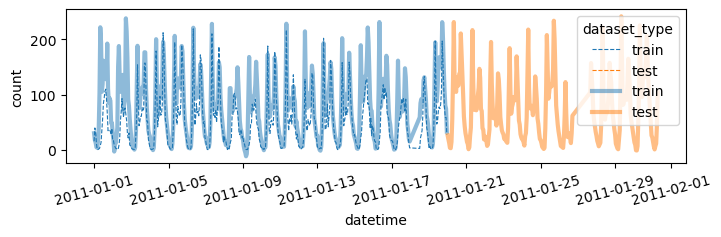

In [38]:
auto(
    df_train_featured.drop(['holiday', 'workingday', 'weekday'], axis = 1),
    df_test_featured.drop(['holiday', 'workingday', 'weekday'], axis = 1)
)

> 오히려 더 안좋아짐...

`-` **왜 이런 결과가 나오는가??**

In [39]:
sex =  np.array([0,0,0,0]*100+[0] + [1]+[1,1,1,1]*100 + [2]*401)
surv = np.array([0,0,0,0]*100+[1] + [0]+[1,1,1,1]*100 + [0]*401) 
surv_conti = surv + np.random.randn(len(surv))*0.1
_df = pd.DataFrame({'sex':sex, 'surv':surv, 'surv_conti':surv_conti})
_df.corr()

,sex,surv,surv_conti
sex,1.00000,-0.002160,0.006710
surv,-0.00216,1.000000,0.978614
surv_conti,0.00671,0.978614,1.000000


<Axes: >

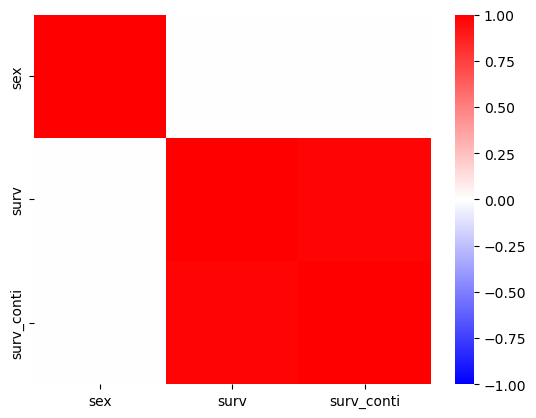

In [40]:
sns.heatmap(_df.corr(), vmin = -1, cmap = 'bwr')

<Axes: xlabel='sex', ylabel='surv_conti'>

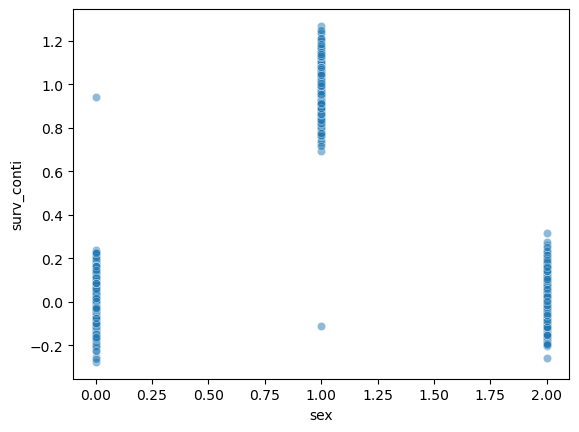

In [41]:
sns.scatterplot(_df, x = 'sex', y = 'surv_conti', alpha = 0.5)

성별에 따라 생존 여부가 크게 차이가 나는 것 같은데 상관계수는 0이다...??

> 범주형 자료로 나타나는 자료간 상관계수는 해석에 유의해야 한다. (성별이 0, 1, 2가 있으면 2일 때 가장 높다...??? $\to$ 이상함)

`-` 분석 자료에 해당 방법을 적용해보자...

* `holiday`는 유효한가??

<Axes: xlabel='holiday', ylabel='count'>

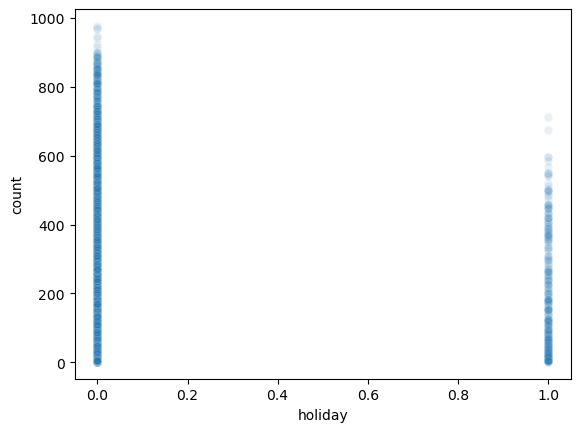

In [42]:
sns.scatterplot(
    df_train_featured,
    x = 'holiday',
    y = 'count',
    alpha = 0.1
)

> 유의할 정도의 차이는 있다. 휴일일 때의 표본이 좀 더 적어서 상관계수가 낮게 나온 것도 있다.

* `weekday`는 유효한가??

<Axes: xlabel='weekday', ylabel='count'>

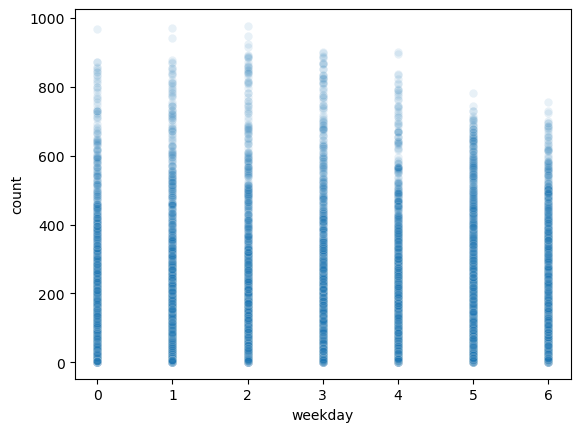

In [43]:
sns.scatterplot(
    df_train_featured,
    x = 'weekday',
    y = 'count',
    alpha = 0.1
)

> 이것도 상관계수가 거의 0이 나올 것, 하지만 분명 의미있는 변수임.

* `workingday`(영업일)은 유의한가?

<Axes: xlabel='workingday', ylabel='count'>

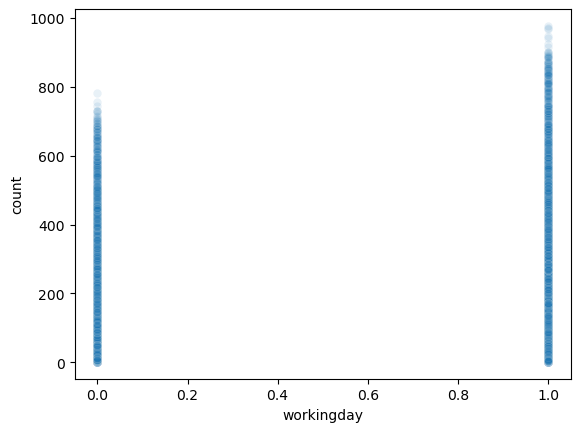

In [44]:
sns.scatterplot(
    df_train_featured,
    x = 'workingday',
    y = 'count',
    alpha = 0.1
)

> 이것도 근무하는 날이 더 많이 빌리는 것 같음...

* 연속형의 경우 악의적으로 꼬기 어렵기 때문에 상관계수를 봐도 됨.
* 범주형의 경우... 원리를 생각해봐야 함.

### **B. Step2 - (다중공선성 열) atemp 혹은 temp 삭제**
---




`-` 지금까지 한 피쳐엔지니어링

In [45]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)
df_test_featured = df_test_featured.drop(['datetime'],axis=1)

<Axes: >

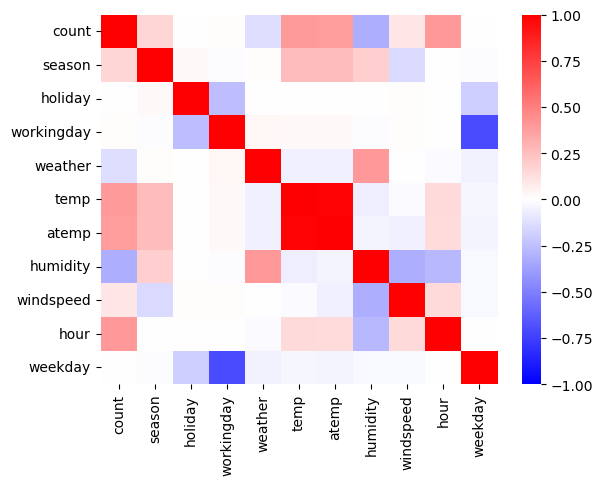

In [46]:
sns.heatmap(df_train_featured.set_index('count').reset_index().corr(), vmin = -1, cmap = 'bwr')

> `temp`와 `atemp`와의 상관계수가 그냥 1에 가깝다. 그냥 똑같은 변수 같음.

<Axes: xlabel='temp', ylabel='atemp'>

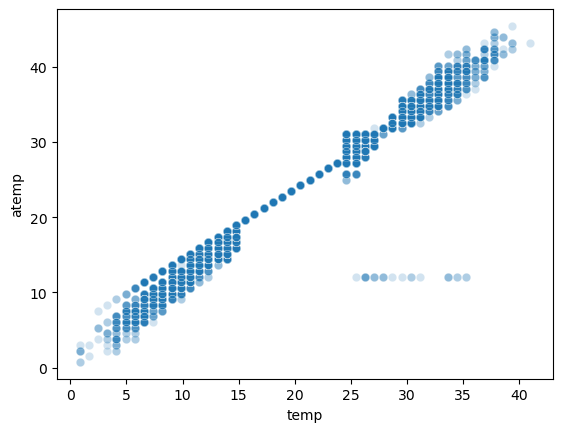

In [47]:
sns.scatterplot(df_train_featured, x = 'temp', y = 'atemp', alpha = 0.2)

> 둘 다 동시에 있을 경우 공선성 문제를 만들 수 있어 보인다. 따라서 둘 중 하나를 제거하는 것이 좋을 것 같음.

In [49]:
## 둘 다 적합해보고 더 좋았던 것을 택하면 됨...
auto(
    df_train_featured.drop(['atemp'], axis = 1),
    df_test_featured.drop(['atemp'], axis = 1)
)

> `atemp`를 제거하는 것이 더 좋았다.

### **C. Step 3 : season을 범주로...?**
---




`-` 지금까지 한 피쳐엔지니어링...

In [50]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)
df_test_featured = df_test_featured.drop(['datetime'],axis=1)
#--#
df_train_featured = df_train_featured.drop(['atemp'],axis=1)  ## atemp 제거 추가
df_test_featured = df_test_featured.drop(['atemp'],axis=1)

`-` `season` 열의 의미는 봄-여름-가을-겨울 순서대로 1,2,3,4이다.

>  이렇게 하면 더미변수가 아닌 연속형 자료로 해석하게 될 텐데, 문자열로 바꾸면 더 좋지 않을까?

In [ ]:
auto(
    df_train_featured.assign(season = df_train_featured.season.map({1:'spring', 2:'summer',3:'fall', 4:'winter'})),
    df_test_featured.assign(season = df_test_featured.season.map({1:'spring', 2:'summer',3:'fall', 4:'winter'}))
)

* 이건 적용하지 않는 게 더 좋았다.
* 리더보드에 있는 모형은 다 트리 계열인데... **어차피 트리계열은 명목형 변수를 순서형 변수로 잘못 적용하더라도 큰 차이 없음**(차피 구간으로 나누니까...)

### **D. Step 4 : $y$의 분포**
---




`-` 지금까지 한 피쳐엔지니어링(계절 범주화는 안했음)

In [51]:
df_train_featured = df_train.copy()
df_test_featured = df_test.copy()
#----# 
df_train_featured = df_train_featured.drop(['casual','registered'],axis=1)
#--#
df_train_featured['hour'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.hour
df_test_featured['hour'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.hour
df_train_featured['weekday'] = df_train_featured['datetime'].apply(pd.to_datetime).dt.weekday
df_test_featured['weekday'] = df_test_featured['datetime'].apply(pd.to_datetime).dt.weekday
#--#
df_train_featured = df_train_featured.drop(['datetime'],axis=1)
df_test_featured = df_test_featured.drop(['datetime'],axis=1)
#--#
df_train_featured = df_train_featured.drop(['atemp'],axis=1)
df_test_featured = df_test_featured.drop(['atemp'],axis=1)

`-` $y$에 어떤 특정한 분포가 적용되지 않을까?

<Axes: >

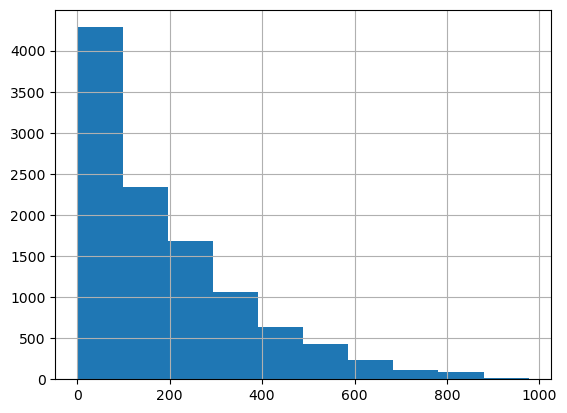

In [52]:
df_train_featured['count'].hist()

> $y$(자전거 대여 수)가 정규분포는 아니네(`count`가 낮은 쪽에 많이 있음)

`-` `count`를 변환하여 적합하고, 역변환하자!

* 변환(로그변환)

In [53]:
transfomr = sklearn.preprocessing.PowerTransformer(method = 'box-cox')  ## 박스콕스 변환!(y값이 클수록 눌러줌)

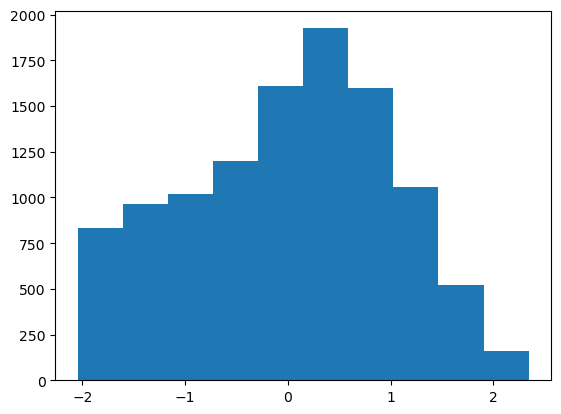

In [54]:
count2 = transfomr.fit_transform(df_train_featured[['count']]).reshape(-1)
plt.hist(count2);

* 적합

In [56]:
## step 1 : pass
## step 2
predictr = TabularPredictor(label = 'count')

## step 3
predictr.fit(df_train_featured.assign(count = count2))  ## 변환한 값 할당

## step 4
yhat = predictr.predict(df_train_featured.assign(count = count2))  ## 마찬가지로 변환한 값을...
yyhat = predictr.predict(df_test_featured)

yhat = transfomr.inverse_transform(yhat.to_frame()).reshape(-1)  ## 역변환, 예상 시 나온 값이 시리즈 형태이므로 데이터프레임 폼으로 바꿔줘야 함
yyhat = transfomr.inverse_transform(yyhat.to_frame()).reshape(-1)

In [ ]:
plotting(yhat, yyhat)

In [ ]:
submit(yyhat)

> 고작 변환만 했을 뿐인데, 모형이 엄청나게 개선된 것을 알 수 있다. 고작 변환만 했을 뿐인데!!